In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize


In [2]:
filenames = ["galaxy1.fits", "galaxy2.fits"]
galaxy_1_coords_pixels = (1833.88, 647.17)
galaxy_2_coords_pixels = (1347.92, 946.57)

coords_pixels = [galaxy_1_coords_pixels, galaxy_2_coords_pixels]

# Plot data
Before we get started, let's see what we're looking at

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
RADECSYS is non-standard, use RADESYSa. [astropy.wcs.wcs]
RADECSYS is non-standard, use RADESYSa.
/Users/egentry/anaconda/lib/python3.4/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")
INFO:astropy:Auto-setting vmin to  1.092e+03
INFO:astropy:Auto-setting vmax to  1.744e+03


INFO: Auto-setting vmin to  1.092e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.744e+03 [aplpy.core]
INFO

INFO:astropy:Auto-setting vmin to  1.086e+03
INFO:astropy:Auto-setting vmax to  1.319e+03


: Auto-setting vmin to  1.086e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.319e+03 [aplpy.core]


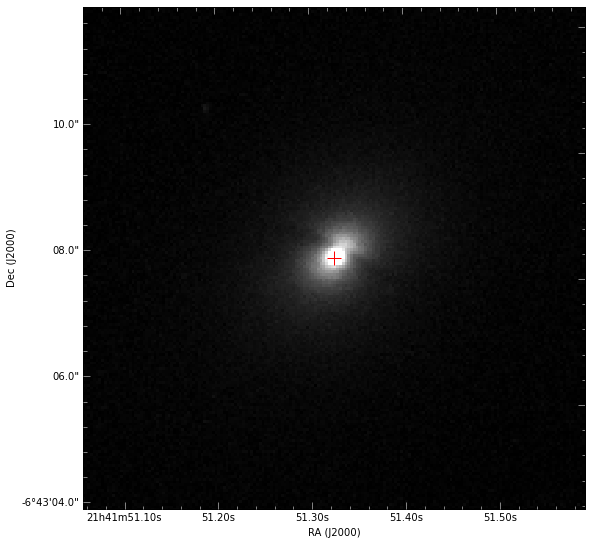

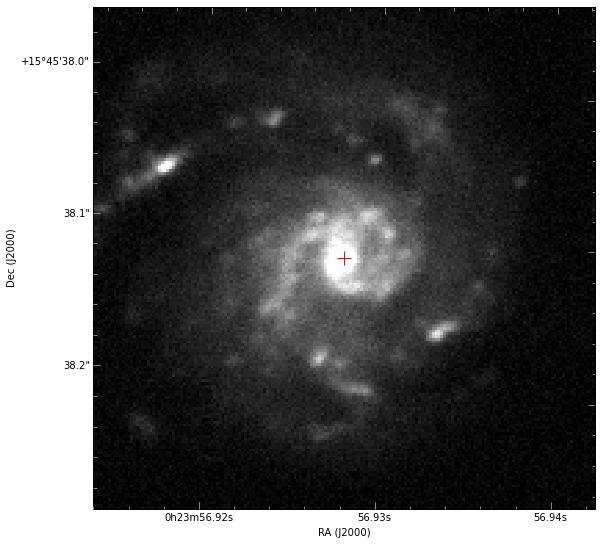

In [3]:
import aplpy


def plot_galaxy(filename, galaxy_coords_pixels):
    plt.figure()
    gal = aplpy.FITSFigure(filename)
    galaxy_coords_wcs = gal.pixel2world(*galaxy_coords_pixels)
    gal.recenter(*galaxy_coords_wcs, radius=.01)

    gal.show_grayscale(stretch="log", pmin=20, pmax=99.95)
    gal.show_markers(*galaxy_coords_wcs,
                     marker="+", color="r", s=200)
    
for filename, galaxy_coords_pixels in zip(filenames, coords_pixels):
    plot_galaxy(filename, galaxy_coords_pixels)

# Read raw data

In [4]:
from astropy.io import fits
galaxy_1_hdulist = fits.open("galaxy1.fits")
galaxy_2_hdulist = fits.open("galaxy2.fits")

See what's in each file:

In [5]:
for filename in filenames:
    hdu_list = fits.open(filename)
    hdu_list.info()
    hdu_list.close()
    print()

Filename: galaxy1.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      77   (2048, 1489)   int16   

Filename: galaxy2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      77   (2048, 1489)   int16   



### getting and using data from FITS files

In [6]:
hdu_list = fits.open(filenames[0])
data = hdu_list[0].data
print("data is type: ", type(data))


data is type:  <class 'numpy.ndarray'>


We can use it for plotting:

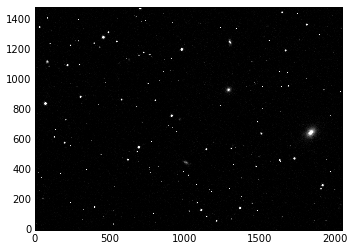

In [7]:
plt.imshow(data, 
           vmin=1100, vmax=1250, 
           aspect="equal", cmap="Greys_r",
           origin="lower")


Or we can do math on it:

In [8]:
rms = np.sqrt((data[200:400 , 800:1000]**2).mean())
print("RMS of arbitrary region: ", rms)

RMS of arbitrary region:  1095.99


# Making brightness vs. distance plots

In [9]:
def create_brightness_distance_arrays(filename, galaxy_coords_pixels, distance_cutoff=100):
    hdu_list = fits.open(filename)
    bias = hdu_list[0].header["softbias"]
    sky  = hdu_list[0].header["sky"]
    data = hdu_list[0].data - bias - sky
    hdu_list.close()
    
    # 1D arrays -- and remember that index [1] corresponds to x in these conventions!
    xs = np.arange(data.shape[1])
    ys = np.arange(data.shape[0])
    
    # 2D arrays of coordinate value at each location
    xxs, yys = np.meshgrid(xs, ys)
    
    gal_x, gal_y = galaxy_coords_pixels
    distance = np.sqrt((xxs - gal_x)**2 + (yys - gal_y)**2)
    
    mask = (distance < distance_cutoff) # & (distance > 1)
    
    return distance[mask], data[mask]


In [10]:
def bin_data(distance, brightness):
    _, bin_edges = np.histogram(distance, bins=50)
    binned_brightnesses = np.empty(len(bin_edges)-1)
    binned_distances    = np.empty(len(bin_edges)-1)
    
    for i in range(len(bin_edges)-1):
        mask = ( (distance > bin_edges[i]) & (distance < bin_edges[i+1]) )
        binned_distances[i]    = distance[mask].mean()
        binned_brightnesses[i] = brightness[mask].mean()
        
    return binned_distances, binned_brightnesses
        
def sersic_profile(r, r_0, I_0, n):
    I = I_0 * np.exp(-(r/r_0)**(1./n))
    return I
    
def fit_data(distance, brightness):    
    p0 = (100, 100, 1)
    
    popt, pcov = optimize.curve_fit(sersic_profile,
                                    distance, brightness,
                                    p0=p0 )

    return popt
    

/Users/egentry/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in power


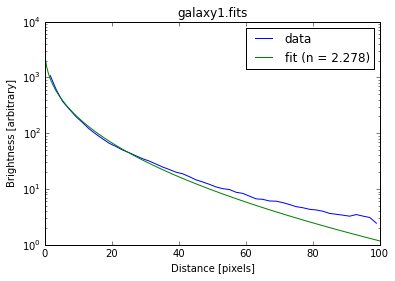

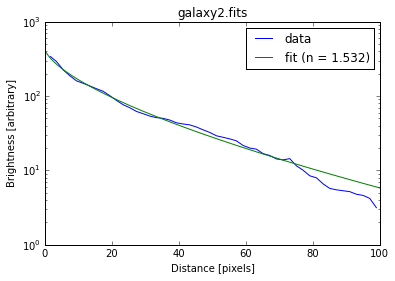

In [11]:
for filename, galaxy_coords_pixels in zip(filenames, coords_pixels):
    distance, brightness = create_brightness_distance_arrays(filename, galaxy_coords_pixels)
    
    binned_distance, binned_brightness = bin_data(distance, brightness)
    params = fit_data(distance, brightness)
    
    plt.figure()
    plt.plot(binned_distance, binned_brightness,
            label="data")
    _dist = np.linspace(distance.min(), distance.max(), num=500)
    plt.plot(_dist, sersic_profile(_dist, *params), 
            label="fit (n = {0:.3f})".format(params[-1]))
    
    plt.title(filename)
    plt.legend(loc="best")
    plt.yscale("log")
    
    plt.xlabel("Distance [pixels]")
    plt.ylabel("Brightness [arbitrary]")
